In [1]:
import gym
import gym_example
from utils import *

In [3]:
from gym_example.envs.adversarial_v62 import Adversarial_v62

# Training protagonist and adversary

To train adversarial v-3, which includes training of the protagonist to compute reward -later it will be regret, when we include both protagonist and antagonist-. For each environment generated by the adversary we can visualize how it looks, shortest path between agent and goal, and the cumulative reward achieved by the protagonist.

### Without running ray

Shortest path:  58
Converting ./models/protagonist/AnimalAI/frozen_graph_def.pb to ./models/protagonist/AnimalAI.nn
GLOBALS: 'is_continuous_control', 'version_number', 'memory_size', 'action_output_shape'
IN: 'visual_observation_0': [-1, 84, 84, 3] => 'policy/main_graph_0_encoder0/conv_1/BiasAdd'
IN: 'vector_observation': [-1, 1, 1, 3] => 'policy/main_graph_0/hidden_0/BiasAdd'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice_1'
OUT: 'policy/concat/concat', 'action'
DONE: wrote ./models/protagonist/AnimalAI.nn file.
PROTAGONIST: 
Steps:  250  Cumulative reward:  -0.9999999310821296  Episode Length:  248.0
Converting ./models/antagonist/AnimalAI/frozen_graph_def.pb to ./models/antagonist/AnimalAI.nn
GLOBALS: 'is_continuous_control', 'version_number', 'memory_size', 'action_output_shape'
IN: 'visual_observation_0': [-1, 84, 84, 3] => 'policy/main_graph_0_encoder0/conv_1/BiasAdd'
IN: 'vector_observation': [-1, 1, 1, 

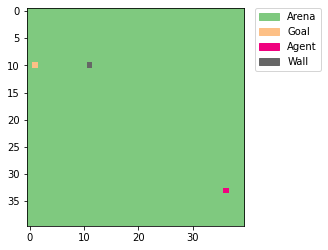

In [2]:
env = gym.make("adversarial-v4")
sum_reward = run_one_episode(env)
print('Sum reward: ', sum_reward)

Shortest path:  21
Converting ./models/protagonist/AnimalAI/frozen_graph_def.pb to ./models/protagonist/AnimalAI.nn
GLOBALS: 'is_continuous_control', 'version_number', 'memory_size', 'action_output_shape'
IN: 'visual_observation_0': [-1, 84, 84, 3] => 'policy/main_graph_0_encoder0/conv_1/BiasAdd'
IN: 'vector_observation': [-1, 1, 1, 3] => 'policy/main_graph_0/hidden_0/BiasAdd'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice_1'
OUT: 'policy/concat/concat', 'action'
DONE: wrote ./models/protagonist/AnimalAI.nn file.
PROTAGONIST: 
Steps:  750  Cumulative reward:  -0.9999999310821296  Episode Length:  248.0
Converting ./models/antagonist/AnimalAI/frozen_graph_def.pb to ./models/antagonist/AnimalAI.nn
GLOBALS: 'is_continuous_control', 'version_number', 'memory_size', 'action_output_shape'
IN: 'visual_observation_0': [-1, 84, 84, 3] => 'policy/main_graph_0_encoder0/conv_1/BiasAdd'
IN: 'vector_observation': [-1, 1, 1, 

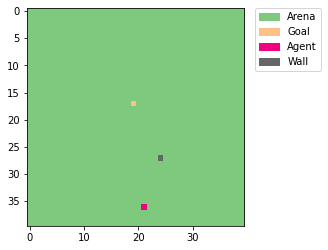

In [4]:
sum_reward = run_one_episode(env)
print('Sum reward: ', sum_reward)

In [5]:
run_id_antagonist = "protagonist"
data_path = 'summaries/' + run_id_antagonist + '_AnimalAI.csv'
df = pd.read_csv(data_path)
print('ANTAGONIST: ')
#print('Steps: ', df.loc[0, 'Steps'], ' Cumulative reward: ', df.loc[0, 'Environment/Cumulative Reward'], \
 #' Episode Length: ', df.loc[0, 'Environment/Episode Length'])
#print('Steps: ', df.loc[int(len(df)/2), 'Steps'], ' Cumulative reward: ', df.loc[int(len(df)/2), 'Environment/Cumulative Reward'], \
 #    ' Episode Length: ', df.loc[int(len(df)/2), 'Environment/Episode Length'])
print('Steps: ', df.loc[len(df)-1, 'Steps'], ' Cumulative reward: ', df.loc[len(df)-1, 'Environment/Cumulative Reward'], \
     ' Episode Length: ', df.loc[len(df)-1, 'Environment/Episode Length'])

ANTAGONIST: 
Steps:  750  Cumulative reward:  -0.9999999310821296  Episode Length:  248.0


In [6]:
df.loc[len(df)-1, 'Environment/Cumulative Reward'] == 'None'

False

## Running ray 

In [7]:
import os
import shutil

chkpt_root = "tmp/w_PAIRED_0"

shutil.rmtree(chkpt_root, ignore_errors=True, onerror=None)
ray_results = "{}/ray_results/".format(os.getenv("HOME"))
shutil.rmtree(ray_results, ignore_errors=True, onerror=None)

In [8]:
import ray

ray.init(ignore_reinit_error=True, local_mode=True)

2021-04-21 17:06:45,505	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '128.179.144.248',
 'raylet_ip_address': '128.179.144.248',
 'redis_address': '128.179.144.248:50790',
 'object_store_address': '/tmp/ray/session_2021-04-21_17-06-44_747984_13548/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-04-21_17-06-44_747984_13548/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-04-21_17-06-44_747984_13548',
 'metrics_export_port': 60620,
 'node_id': 'be630bfe5b3d6450a3d7029498f2ecf634158a5e3972718c298c3278'}

In [9]:
from ray.tune.registry import register_env
from gym_example.envs.adversarial_v4 import Adversarial_v4
import ray.rllib.agents.ppo as ppo

select_env = "adversarial-v4"
register_env(select_env, lambda config: Adversarial_v4())

config = ppo.DEFAULT_CONFIG.copy()

config['num_workers'] = 0
config["log_level"] = "WARN"
config["train_batch_size"] = 1
config["sgd_minibatch_size"] = 1
config["num_sgd_iter"] = 1
config["timesteps_per_iteration"] = 4
config["rollout_fragment_length"] = 1

config["log_level"] = "WARN"
agent = ppo.PPOTrainer(config, env=select_env)

2021-04-21 17:06:47,275	INFO trainer.py:616 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2021-04-21 17:06:47,276	INFO trainer.py:643 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2021-04-21 17:06:47,302	WARNING deprecation.py:34 -- DeprecationWarning: `framestack` has been deprecated. Use `num_framestacks (int)` instead. This will raise an error in the future!
2021-04-21 17:06:50,108	WARNING util.py:47 -- Install gputil for GPU system monitoring.


2021-04-21 17:06:58,626	WARNING deprecation.py:34 -- DeprecationWarning: `env_index` has been deprecated. Use `episode.env_id` instead. This will raise an error in the future!


Shortest path:  40
Converting ./models/protagonist/AnimalAI/frozen_graph_def.pb to ./models/protagonist/AnimalAI.nn
GLOBALS: 'is_continuous_control', 'version_number', 'memory_size', 'action_output_shape'
IN: 'visual_observation_0': [-1, 84, 84, 3] => 'policy/main_graph_0_encoder0/conv_1/BiasAdd'
IN: 'vector_observation': [-1, 1, 1, 3] => 'policy/main_graph_0/hidden_0/BiasAdd'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice_1'
OUT: 'policy/concat/concat', 'action'
DONE: wrote ./models/protagonist/AnimalAI.nn file.
PROTAGONIST: 
Steps:  250  Cumulative reward:  -0.9999999310821296  Episode Length:  248.0
Converting ./models/antagonist/AnimalAI/frozen_graph_def.pb to ./models/antagonist/AnimalAI.nn
GLOBALS: 'is_continuous_control', 'version_number', 'memory_size', 'action_output_shape'
IN: 'visual_observation_0': [-1, 84, 84, 3] => 'policy/main_graph_0_encoder0/conv_1/BiasAdd'
IN: 'vector_observation': [-1, 1, 1, 

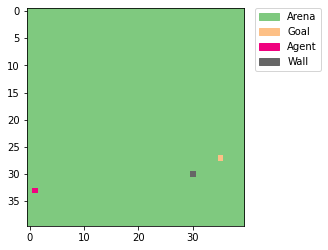

2021-04-21 17:21:56,308	ERROR import_thread.py:89 -- ImportThread: Connection closed by server.


In [10]:
status = "{:2d} reward {:6.2f}/{:6.2f}/{:6.2f} len {:4.2f} saved {}"
n_iter = 1
for n in range(n_iter):
    result = agent.train()
    chkpt_file = agent.save(chkpt_root)
    print(status.format(
            n + 1,
            result["episode_reward_min"],
            result["episode_reward_mean"],
            result["episode_reward_max"],
            result["episode_len_mean"],
            chkpt_file
            ))